![Caption](images/Q10.png)

### MNIST Training Notes

* Completely naïve on 1000 training images and 100 valid images we obtain accuracies in the 80% on the validation set at the end of 10 epochs.
* We then implement batches from which we see more volatile loss, but faster convergence due to better memory utilization (at least in theory on GPU)
* We also will not get caught in local minima since the batches make the gradient descent stochastic (due to shuffling of batches after each epoch)
* We implemented adaptive learning rate as described in the article A Stochastic Approximation Method by Monro. This is where $\eta_i = \eta_{constant}\frac{1}{i}$ where $i$ is the epoch number.
* We use Glorot initialization for our weights (which we found as being state of the art).
* With these additional measures we get much better stability in the convergence of the training such that the range of validation scores lie between $88\%$ and $91\%$. Here we saw a lot of overfitting if we increased the layers of the model so we now made Dropout to regularize the model.
* Now we obtained an accuracy of $93.6\%$ accuracy!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#%%
f = open('train-images-idx3-ubyte', 'r')
a = np.fromfile(f, dtype='>i4', count=4)
images = np.fromfile(f, dtype='u1')

im = np.reshape(images[0:(28*28)],(28,28))
fig, ax = plt.subplots(1,1)
ax.imshow(im)
plt.title('MNST')
fig.show
#%%
f = open('train-labels-idx1-ubyte', 'r')
t = np.fromfile(f, count = 2, dtype='>i4')
labels = np.fromfile(f, dtype='u1')
images = images.reshape((int(len(images)/(28*28)), 28*28))
images = images.astype(float)
images = images/255
labels = labels.reshape((len(labels), 1))
labels = labels.astype(int)

In [2]:
from scipy.special import softmax
import math
def init_weights_bias(neurons_in_layers):
    W = []
    b = []
    for i in range(len(neurons_in_layers)-1):
        std = math.sqrt(2)*math.sqrt(2.0/(float(neurons_in_layers[i])+float(neurons_in_layers[i+1])))
        W.append(np.random.normal(loc=0.0, scale=std, size=[neurons_in_layers[i],neurons_in_layers[i+1]])) 
        b.append(np.random.normal(loc=0.0, scale=std, size=[1, neurons_in_layers[i+1]])) 
    return (W, b)
def forward_pass(NN, x):
    #x: The input of the network             (np.array of shape: (batch_size, number_of_features))
    #NN: The initialized neural network      (tuple of list of matrices)
    z = [x]
    a = []
    for l in range(len(NN[0])):
        a.append(np.einsum('bi, io -> bo', z[l], NN[0][l]) + NN[1][l])  # The affine transform x*w+b
        if l+1 != len(NN[0]):
            z.append(np.maximum(a[l], 0))
        else:
            z.append(softmax(a[l], axis=1))
    return z, a

def backward_pass(x, t, z, a, NN):
    y = z[-1] #Apply softmax to z to get probability of each class
    delta = y-t # Delta for the last layer
    d_a = []
    for i in range(len(a)):
        d_a.append(z[i])
    g_w = [] 
    g_b = []
    g_b.append(np.mean(delta, axis=0))
    g_w.append(np.mean(np.einsum('bo, bi -> bio', delta, z[-2]), axis=0))
    
    for l in range(1, len(NN[0])):
        d_C_d_z = np.einsum('bo, io -> bi', delta, NN[0][-l])  # Derivative of the Cost with respect to an activated layer d_C_d_z. 
                                                               #  delta shape: as above; weights shape: (i, o)
                                                               # Delta: d_C_d_z (element-wise mult) derivative of the activation layers
                                                               #  delta shape: as above; d_z shape: (b, i)  
        delta = np.einsum('bi, bi -> bi', d_C_d_z, d_a[-l])     # <- Insert correct expression                                      
        g_b.append(np.mean(delta, axis=0)) 
        g_w.append(np.mean(np.einsum('bo, bi -> bio', delta, z[-l-2]), axis=0)) # Derivative of cost with respect to weights in layer l:
                                                                           # delta shape: as above; activations of l-1 shape: (b, i)
    return g_b[::-1], g_w[::-1]

def normalize_data(data):
    print(data[0])
    train_mu = np.mean(data, axis=0)
    train_sigma = np.std(data, axis=0)
    data = data-train_mu/train_sigma
    return data
    
def cross_entropy_loss(target, y, derivative=False):
    """
    Computes the cross entropy loss function and its derivative 
    Input:
    target:      target (expected output)          (np.array)
    y:      output from forward pass (np.array, must be the same shape as t)
    derivative: whether to return the derivative with respect to y or return the loss (boolean)
    """
    if derivative:
        return (y-t)
    else:
        return -target*np.log(y) 

Accuracy obtained on test set: 90.0


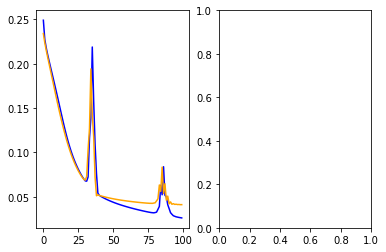

In [15]:
def make_target_array(data):
    new_data = []
    for label in data:
        labels = []
        for i in range(10):
            if i == label:
                labels.append(1)
            else:
                labels.append(0)
        labels = np.array(labels)
        new_data.append(labels)
    return np.array(new_data)

X = images[:1000]
T = make_target_array(labels[:1000])
layers = [28*28, 32, 10]
eta = 0.1
NN = init_weights_bias(layers)
test_x = images[-100:]
test_labels = make_target_array(labels[-100:])
train_loss = []
valid_loss = []
for i in range(100):
    z, a = forward_pass(NN, X)
    g_b, g_w = backward_pass(X, T, z, a, NN)
    train_loss.append(np.mean(cross_entropy_loss(T, z[-1])))
    for l in range(len(g_b)):
            NN[0][l] -= g_w[l]*eta
            NN[1][l] -= g_b[l]*eta
    z, a = forward_pass(NN, test_x)
    valid_loss.append(np.mean(cross_entropy_loss(test_labels, z[-1])))
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(train_loss, color = "blue")
ax1.plot(valid_loss, color = "orange")

correct = 0
for pair in zip(z[-1], test_labels):
    if np.argmax(pair[0]) == np.argmax(pair[1]):
        correct += 1
 
print("Accuracy obtained on test set: " + str(correct/len(test_labels)*100))


0.04250198974190206
0.032864708698583635
0.029112076199352764
0.026937841383563504
0.026609434638331885
0.02585729386271949
0.025261435530605666
0.025585750768945873
0.02575461986924724
0.02470344282459721
0.0259960323233333
0.024159341037303758
0.024709058686309397
0.024343748554570836
0.02434142726281579
0.024422239989250902
0.024144217607182605
0.023845298869173193
0.02401387655458133
0.0246298367695548
Accuracy obtained on test set: 93.60000000000001


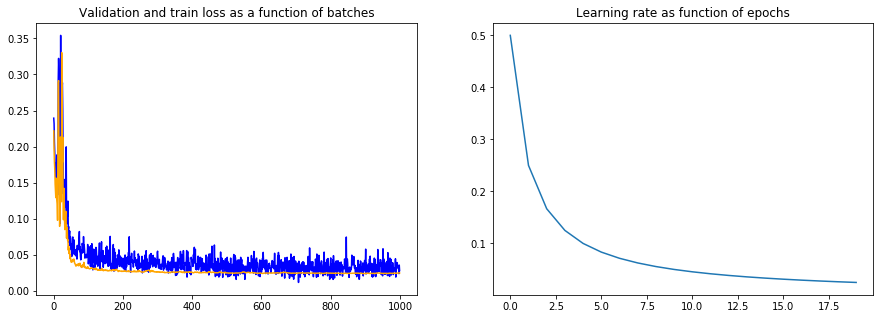

In [100]:
import random
import copy
def make_target_array(data):
    new_data = []
    for label in data:
        labels = []
        for i in range(10):
            if i == label:
                labels.append(1)
            else:
                labels.append(0)
        labels = np.array(labels)
        new_data.append(labels)
    return np.array(new_data)
def dropout(layer_shape, dropout_rate):
    weights_shape = layer_shape[1]
    dropout_weights = np.random.binomial(1, dropout_rate, weights_shape)
    train_weights = np.ones(weights_shape)-dropout_weights
    mat_dropout = np.diag(dropout_weights)
    mat_train = np.diag(train_weights)
    return mat_dropout, mat_train
def forward_pass_test(NN, x, dropout_rate):
    #x: The input of the network             (np.array of shape: (batch_size, number_of_features))
    #NN: The initialized neural network      (tuple of list of matrices)
    z = [x]
    a = []
    for l in range(len(NN[0])):
        if l == 0:
            a.append((np.einsum('bi, io -> bo', z[l], NN[0][l]) + NN[1][l])*(1-dropout_rate))  # The affine transform x*w+b
        else:
            a.append(np.einsum('bi, io -> bo', z[l], NN[0][l]) + NN[1][l])  # The affine transform x*w+b
        if l+1 != len(NN[0]):
            z.append(np.maximum(a[l], 0))
        else:
            z.append(softmax(a[l], axis=1))
    return z, a
im_to_include = 5000
X = images[:im_to_include]
T = make_target_array(labels[:im_to_include])
layers = [28*28, 1024, 10]
eta_start = 0.5
NN = init_weights_bias(layers)
test_x = images[-1000:]
test_labels = make_target_array(labels[-1000:])
train_loss = []
valid_loss = []
etas = []
batch_size = 100
dropout_rate = 0.5
batches_per_epoch = int(im_to_include/batch_size)
epochs = 20
for i in range(epochs):
    eta = eta_start*(1/(i+1))
    etas.append(eta)
    for i in range(batches_per_epoch):
        batch_X = X[i*batch_size:(i+1)*batch_size]
        batch_T = T[i*batch_size:(i+1)*batch_size]
        NN_old = NN[0][0]
        mat_dropout, mat_train = dropout(NN[0][0].shape, dropout_rate)
        NN[0][0] = np.einsum('bi, ii -> bi', NN[0][0], mat_train)
        z, a = forward_pass(NN, batch_X)
        g_b, g_w = backward_pass(batch_X, batch_T, z, a, NN)
        train_loss.append(np.mean(cross_entropy_loss(batch_T, z[-1])))
        for l in range(len(g_b)):
                NN[0][l] -= g_w[l]*eta
                NN[1][l] -= g_b[l]*eta
        NN[0][0] = np.einsum('bi, ii -> bi', NN[0][0], mat_train) + np.einsum('bi, ii -> bi', NN_old, mat_dropout)
        z, a = forward_pass_test(NN, test_x, dropout_rate)
        valid_loss_batch = np.mean(cross_entropy_loss(test_labels, z[-1]))
        valid_loss.append(valid_loss_batch)
    zipped_data = list(zip(X,T))

    random.shuffle(zipped_data)
    X = np.array([ sample[0] for sample in zipped_data ])
    T = np.array([ sample[1] for sample in zipped_data ])
    print(valid_loss_batch)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches((15,5))
ax1.plot(train_loss, color = "blue")
ax1.plot(valid_loss, color = "orange")
ax1.set_title("Validation and train loss as a function of batches")
ax2.plot(etas)
ax2.set_title("Learning rate as function of epochs")

correct = 0
for pair in zip(z[-1], test_labels):
    if np.argmax(pair[0]) == np.argmax(pair[1]):
        correct += 1
print("Accuracy obtained on test set: " + str(correct/len(test_labels)*100))


In [77]:
NN = np.array([[1, 1],[2,2]])
NN_old = [[10, 10],[20,20]]
def dropout(layer_shape, dropout_rate):
    weights_shape = layer_shape[1]
    dropout_weights = np.random.binomial(1, dropout_rate, weights_shape)
    train_weights = np.ones(weights_shape)-dropout_weights
    mat_dropout = np.diag(dropout_weights)
    mat_train = np.diag(train_weights)
    return mat_dropout, mat_train
mat_dropout, mat_train = dropout(NN.shape, 0.5)
print(mat_dropout)
NN = np.einsum('bi, ii -> bi', NN, mat_train) + np.einsum('bi, ii -> bi', NN_old, mat_dropout)
print(NN)

[[1 0]
 [0 0]]
[[10.  1.]
 [20.  2.]]
